# Testing functions

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn.decomposition import PCA
import scipy.io as sio
import os
from tqdm.auto import tqdm

sns.set_style('white')
# to change default color cycle
cs = ['#616F85', '#C2BAA3', '#F5E6CE', '#DD9D7C', '#C9445F']
csbr = ['#074B6A', '#0A82A4', '#C0E995', '#3F9552', '#F3EE7E', '#E64248', '#E35330']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=csbr)

import pyaldata as pld # using functions from PyalData
import tools # matlab2python functions

## Load data

In [2]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = pld.mat2dataframe(path+fname, shift_idx_fields=True)

## Read cmp file

In [13]:
def cleanup_text(s):
    ''' Removes .cmp file formatting '''
    for r in (('\t', ' '), ('\n', ''), ('elec', '')):
        s = s.replace(*r)
    s = s.split()        
    return s

In [51]:
def read_cmp(cmp_file):
    '''
    reads Blackrock .cmp file into Python
    
    Parameters
    ----------
    cmp_file: str
        string file path to .cmp file
        
    Returns
    -------
    elec_map: dataframe of shape (96, 5)
        [col (int), row (int), channel number (str), within_channel_num (int), global electrode number (int)]
    '''
    
    f = open(cmp_file)
    # remove comments in file
    temp = [line for line in f.readlines() if not line.startswith('//')] 
    pre_df = [cleanup_text(row) for i, row in enumerate(temp) if not i == 0] 
    df = pd.DataFrame(pre_df, columns=['array_col', 'array_row', 'channel_num', 'within_channel_num', 'global_enum']).dropna()

    # ugly way to convert all possible cols to int.. to be improved
    for i in df.columns:
        try: df[[i]] = df[[i]].astype(str).astype(int) 
        except: pass
    
    return df

In [46]:
def show_electrode_pos(elec_map, elecs, verbose=False):
    '''
    Display the position of specified electrodes on the array
    
    Parameters
    ----------
    elec_map: 
    
    elecs: the electrodes for which you want to get the position
    
    Returns
    -------
    
    A: np.array
        matrix with the spatial position of the electrodes
    
    '''
    # construct multi electrode array (assuming 10x10)
    A = np.zeros((10,10))
    
    for elec in elecs:
        if elec in elec_map['global_enum'].values:
            # find corresponding row and column in array
            r = int(elec_map.loc[elec_map['global_enum'] == elec]['array_row'])
            c = int(elec_map.loc[elec_map['global_enum'] == elec]['array_col'])
            A[r, c] = elec
        else:
            if verbose:
                print(f'Electrode number {elec} does not exist in array \n')
    
    if verbose:
        fig, ax = plt.subplots(1, figsize=(5,5), dpi=80)
        sns.heatmap(A, cmap='gray', annot=True, vmin=0, vmax=1, cbar=False, ax=ax)
    
    return A

In [47]:
elec_map = read_cmp(cmp_file='/Users/Daphne/Desktop/Chewie Left M1 SN 6250-001474.cmp')

In [49]:
elec_map.shape

(96, 5)

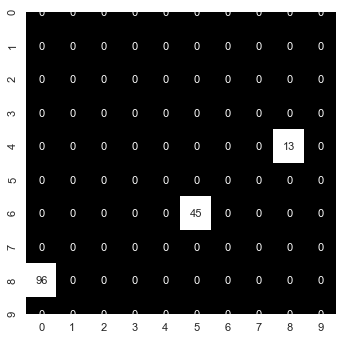

In [48]:
A = show_electrode_pos(elec_map, elecs=[96, 13, 45], verbose=True)

## Inspect unit guides for M1 and PMd


In [42]:
df['M1_spikes']

0      [[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,...
1      [[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,...
2      [[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...
3      [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4      [[0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,...
                             ...                        
769    [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,...
770    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
771    [[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
772    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...
773    [[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: M1_spikes, Length: 774, dtype: object

In [44]:
df['M1_spikes'][0]

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]], dtype=uint8)

In [3]:
'''
The unit guide specifies how many cells each electrode covers.
This is for each trial in the data. 

[Electrode number, # cells that electrode covers]
'''

df['M1_unit_guide']

0      [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
1      [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
2      [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
3      [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
4      [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
                             ...                        
769    [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
770    [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
771    [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
772    [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
773    [[5, 1], [5, 2], [5, 3], [5, 4], [9, 1], [9, 2...
Name: M1_unit_guide, Length: 774, dtype: object

In [12]:
#df['PMd_unit_guide'][0]

In [5]:
num_cells_elec_m1 = []
num_cells_elec_pmd = []

for i in range(df['M1_unit_guide'].shape[0]):
    num_cells_elec_m1.append(df['M1_unit_guide'][i][:, 1])
    num_cells_elec_pmd.append(df['PMd_unit_guide'][i][:, 1])
    
num_cells_elec_m1 = np.concatenate(num_cells_elec_m1, axis=0)
num_cells_elec_pmd = np.concatenate(num_cells_elec_pmd, axis=0)

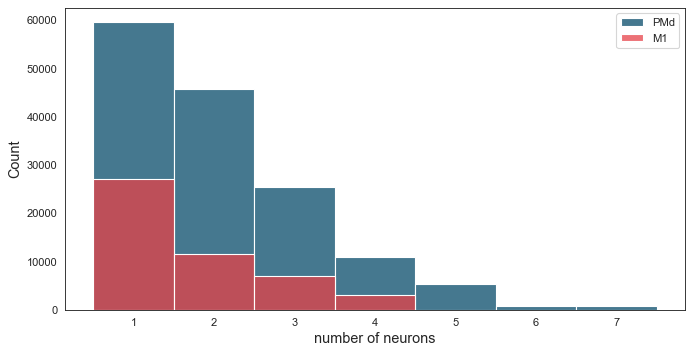

In [6]:
fig, ax = plt.subplots(1, figsize=(10,5), dpi=80)
sns.histplot(data=num_cells_elec_pmd, ax=ax, discrete=True, label='PMd')
sns.histplot(data=num_cells_elec_m1, ax=ax, discrete=True, label='M1', color=csbr[5])
ax.set_xlabel('number of neurons', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.legend();

//   legend					

//   col - 0 based column from left to right					

//   row - 0 based row from bottom to top					

//   bank - bank name - values can be A B C or D					

//   elec - 1 based electrode number within the bank - values can be 1-32					

//   label - label used to rename channels in Central (optional)					

Cerebus mapping for array 13965-21    SN: 6250-001474				

- Find list of cells on each electrode
- Which cells belong to which electrode?

1. Make function that reads a cmp file
2. Use this function to get the right mapping
3. 

In [7]:
'''
Find out which cell belongs to which electrode
'''

elecs = np.arange(0, 96)

# make arrays to store cells in elecs
m1_units = np.zeros(len(elecs))
pmd_units = np.zeros(len(elecs))

# for i in range(len(elecs)):
#     # m1
#     m1_units[i] = np.where() # store indices that belong to a certain electrode
#     # pmd

Reading a cmp file into Python 